In [46]:
"""
In this lab, we once again have a mandatory 'python' challenge.
Then we have a more open-ended Machine Learning 'see why' challenge.

This data is the "Is Wikipedia Literary" that I pitched.
You can contribute to science or get a sense of the data here: https://label.jjfoley.me/wiki
"""

import gzip, json
from shared import dataset_local_path, TODO
from dataclasses import dataclass
from typing import Dict, List
# new helpers:
from shared import dataset_local_path, bootstrap_accuracy, simple_boxplot, TODO, bootstrap_auc
from sklearn.neural_network import MLPClassifier

In [17]:
"""
Problem 1: We have a copy of Wikipedia (I spared you the other 6 million pages).
It is separate from our labels we collected.
"""


@dataclass
class JustWikiPage:
    title: str
    wiki_id: str
    body: str


# Load our pages into this pages list.
pages: List[JustWikiPage] = []
with gzip.open(dataset_local_path("tiny-wiki.jsonl.gz"), "rt") as fp:
    for line in fp:
        entry = json.loads(line)
        pages.append(JustWikiPage(**entry))


@dataclass
class JustWikiLabel:
    wiki_id: str
    is_literary: bool


# Load our judgments/labels/truths/ys into this labels list:
labels: List[JustWikiLabel] = []
with open(dataset_local_path("tiny-wiki-labels.jsonl")) as fp:
    for line in fp:
        entry = json.loads(line)
        labels.append(
            JustWikiLabel(wiki_id=entry["wiki_id"], is_literary=entry["truth_value"])
        )


@dataclass
class JoinedWikiData:
    wiki_id: str
    is_literary: bool
    title: str
    body: str

In [6]:
print(len(pages), len(labels))

1904 1904


In [7]:
print(pages[0])

JustWikiPage(title='WTYB', wiki_id='enwiki:WTYB', body='WTYB (103.9 FM) is a radio station licensed to serve Bluffton, Georgia, United States.  The station is owned by Cumulus Broadcasting.\n\nIt broadcasts an Urban AC music format targeted to Savannah, Georgia.\n\nOriginally launched as WGEC, licensed to Springfield, Georgia, in March 1978, this station first aired an urban adult contemporary music format from 1998-2003 as WSIS "Kiss 104" and then as "V103.9".  Briefly in 2005, the station aired an Oldies format as "Cool 103.9."\n\nThe station was assigned the WTYB call letters by the Federal Communications Commission on July 9, 2004. After stunting with Christmas music and the greatest hits of Johnny Cash, the station debuted as "Magic 103.9" with an Urban AC format on January 8, 2006.\n\nIn November 2007, Cumulus attempted to transfer ownership of WTYB to a trustee, Stratus Radio LLC, with the intention of selling it to another owner in order to meet FCC ownership caps. That deal, h

In [9]:
print(labels[0])

JustWikiLabel(wiki_id='enwiki:The%20Waiting%20(album)', is_literary=False)


In [10]:
joined_data: Dict[str, JoinedWikiData] = {}

### 1. create a list of JoinedWikiData from the ``pages`` and ``labels`` lists.

In [11]:
# for p in pages:
#     joined_data[p.wiki_id] = JoinedWikiData(
#         p.wiki_id, is_literary=False, title=p.title, body=p.body
#     )
# for l in labels:
#     joined_data[l.wiki_id].is_literary = l.is_literary

In [42]:
############### Problem 1 ends here ###############

# Make sure it is solved correctly!
assert len(joined_data) == len(pages)
assert len(joined_data) == len(labels)
# Make sure it has *some* positive labels!
assert sum([1 for d in joined_data.values() if d.is_literary]) > 0
# Make sure it has *some* negative labels!
assert sum([1 for d in joined_data.values() if not d.is_literary]) > 0

# Construct our ML problem:
ys = []
examples = []
for wiki_data in joined_data.values():
    ys.append(wiki_data.is_literary)
    examples.append(wiki_data.body)

## We're actually going to split before converting to features now...
from sklearn.model_selection import train_test_split
import numpy as np

RANDOM_SEED = 1234

## split off train/validate (tv) pieces.
ex_tv, ex_test, y_tv, y_test = train_test_split(
    examples,
    ys,
    train_size=0.75,
    shuffle=True,
    random_state=RANDOM_SEED,
)
# split off train, validate from (tv) pieces.
ex_train, ex_vali, y_train, y_vali = train_test_split(
    ex_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

## Convert to features, train simple model (TFIDF will be explained eventually.)
from sklearn.feature_extraction.text import TfidfVectorizer

# Only learn columns for words in the training data, to be fair.
word_to_column = TfidfVectorizer(
    strip_accents="unicode", lowercase=True, stop_words="english", max_df=0.5
)
word_to_column.fit(ex_train)

# Test words should surprise us, actually!
X_train = word_to_column.transform(ex_train)
X_vali = word_to_column.transform(ex_vali)
X_test = word_to_column.transform(ex_test)


print("Ready to Learn!")
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score



models = {
    "SGDClassifier": SGDClassifier(),
    "Perceptron": Perceptron(),
    "LogisticRegression": LogisticRegression(),
    "DTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "MLPClassifier": MLPClassifier()
}


# for d in range(1,20):
#     models["Dtree-{}".format(d)] = DecisionTreeClassifier(max_depth=d)
fit_models = []
for name, m in models.items():
    m.fit(X_train, y_train)
    print("{}:".format(name))
    print("\tVali-Acc: {:.3}".format(m.score(X_vali, y_vali)))
    if hasattr(m, "decision_function"):
        scores = m.decision_function(X_vali)
    else:
        scores = m.predict_proba(X_vali)[:, 1]
    fit_models.append(m)
    print("\tVali-AUC: {:.3}".format(roc_auc_score(y_score=scores, y_true=y_vali)))

Ready to Learn!
SGDClassifier:
	Vali-Acc: 0.844
	Vali-AUC: 0.883
Perceptron:
	Vali-Acc: 0.813
	Vali-AUC: 0.853
LogisticRegression:
	Vali-Acc: 0.79
	Vali-AUC: 0.88


/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


DTree:
	Vali-Acc: 0.767
	Vali-AUC: 0.742
RandomForest:
	Vali-Acc: 0.778
	Vali-AUC: 0.834


/Users/Alderik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MLPClassifier:
	Vali-Acc: 0.844
	Vali-AUC: 0.876


In [40]:
# """
# Results should be something like:

# SGDClassifier:
#         Vali-Acc: 0.84
#         Vali-AUC: 0.879
# Perceptron:
#         Vali-Acc: 0.815
#         Vali-AUC: 0.844
# LogisticRegression:
#         Vali-Acc: 0.788
#         Vali-AUC: 0.88
# DTree:
#         Vali-Acc: 0.739
#         Vali-AUC: 0.71
# """

### 2. Explore why DecisionTrees are not beating linear models. Answer one of:

#### 2.A. Is it a bad depth?"

with 32,000 features the decision tree then needs to go super deep to be able to split. 

#### 2.B. Do Random Forests do better?

Yes, it avoids the decision trees tendency to overfit which mean it will generalize poorly on data other than the training data. 

#### 2.C. Is it randomness? Use simple_boxplot and bootstrap_auc/bootstrap_acc to see if the differences are meaningful!

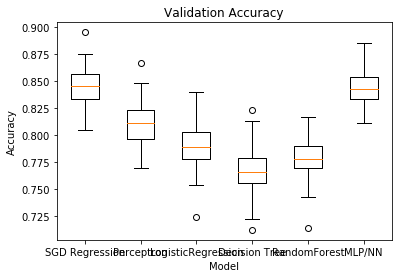

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [50]:
%matplotlib inline

# Helper method to make a series of box-plots from a dictionary:
simple_boxplot(
    {
        "SGD Regression": bootstrap_accuracy(fit_models[0], X_vali, y_vali),
        "Perceptron": bootstrap_accuracy(fit_models[1], X_vali, y_vali),
        "LogisticRegression": bootstrap_accuracy(fit_models[2], X_vali, y_vali),
        "Decision Tree": bootstrap_accuracy(fit_models[3], X_vali, y_vali),
        "RandomForest": bootstrap_accuracy(fit_models[4], X_vali, y_vali),
        "MLP/NN": bootstrap_accuracy(fit_models[5], X_vali, y_vali),
    },
    title="Validation Accuracy",
    xlabel="Model",
    ylabel="Accuracy",
)

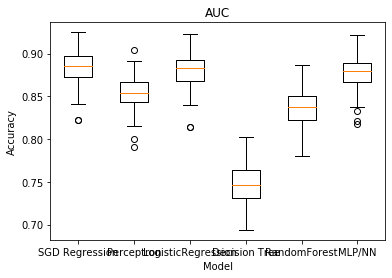

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [52]:
simple_boxplot(
    {
        "SGD Regression": bootstrap_auc(fit_models[0], X_vali, y_vali),
        "Perceptron": bootstrap_auc(fit_models[1], X_vali, y_vali),
        "LogisticRegression": bootstrap_auc(fit_models[2], X_vali, y_vali),
        "Decision Tree": bootstrap_auc(fit_models[3], X_vali, y_vali),
        "RandomForest": bootstrap_auc(fit_models[4], X_vali, y_vali),
        "MLP/NN": bootstrap_auc(fit_models[5], X_vali, y_vali),
    },
    title="AUC",
    xlabel="Model",
    ylabel="Accuracy",
)

#### 2.D. Is it randomness? Control for random_state parameters! 